Mounted at /content/drive
🔄 Unzipping dataset...
✅ Dataset unzipped
✅ Dataset structure verified
Found 1997 files belonging to 3 classes.
Using 1598 files for training.
Found 1997 files belonging to 3 classes.
Using 399 files for validation.
Found 301 files belonging to 3 classes.
Classes: ['early', 'moderate', 'severe']
Class weights: {0: np.float64(1.076094276094276), 1: np.float64(0.8661246612466125), 2: np.float64(1.0915300546448088)}
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3_Severity"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,971 (13.32 MB)

 Trainable params: 494,595 (1.89 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 62s 600ms/step - accuracy: 0.4440 - loss: 1.4429 - val_accuracy: 0.6140 - val_loss: 0.8147
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.5723 - loss: 1.0287 - val_accuracy: 0.6516 - val_loss: 0.7153
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.5913 - loss: 0.9553 - val_accuracy: 0.6416 - val_loss: 0.7179
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.6376 - loss: 0.8351 - val_accuracy: 0.6491 - val_loss: 0.7078
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.6121 - loss: 0.9233 - val_accuracy: 0.6566 - val_loss: 0.7131
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.6598 - loss: 0.8204 - val_accuracy: 0.6642 - val_loss: 0.7121
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - accuracy: 0.6333 - loss: 0.8316 - val_accuracy: 0.6717 - val_loss: 0.7308
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.6545 - loss: 0.7802 - val_accu

✅ Model saved at: /content/drive/MyDrive/SeverityModels/mobilenetv3/mobilenetv3_final.keras


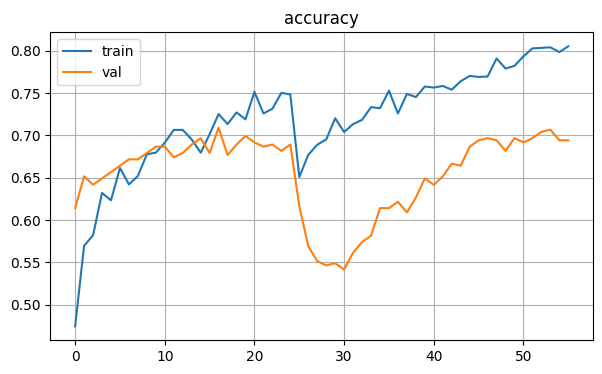

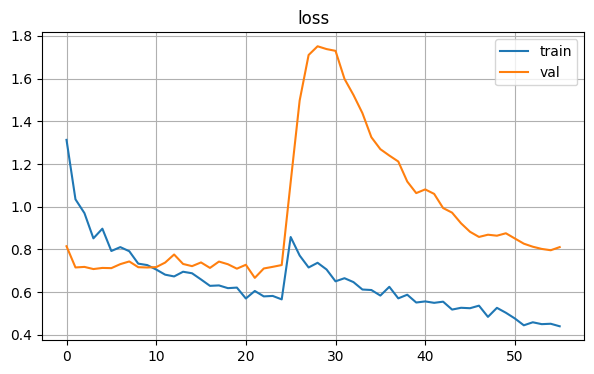

In [ ]:
# ============================================================
# MobileNetV3 Severity Classification – FINAL FIXED VERSION
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

# ------------------------------------------------------------
# 1. Paths
# ------------------------------------------------------------
DATASET_ZIP_PATH = "/content/drive/MyDrive/BetelLeafDataset/SeverityDataset.zip"
DATASET_PATH = "/content/SeverityDataset"
TEST_PATH = "/content/drive/MyDrive/BetelLeafDataset/SeverityDataset_test"
SAVE_MODELS_DIR = "/content/drive/MyDrive/SeverityModels/mobilenetv3"

import tensorflow as tf
import os, zipfile, shutil
os.makedirs(SAVE_MODELS_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2. Unzip dataset ONCE
# ------------------------------------------------------------
if not os.path.exists(DATASET_PATH):
    print("🔄 Unzipping dataset...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as z:
        z.extractall("/content")
    print("✅ Dataset unzipped")

# Verify structure
for cls in ["early", "moderate", "severe"]:
    if not os.path.isdir(os.path.join(DATASET_PATH, cls)):
        raise FileNotFoundError(f"❌ Missing class folder: {cls}")

print("✅ Dataset structure verified")


# ------------------------------------------------------------
# 3. Imports & Parameters
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

IMG_SIZE = 224
BATCH_SIZE = 24
AUTOTUNE = tf.data.AUTOTUNE

HEAD_EPOCHS = 25
FT_EPOCHS = 30
LR_HEAD = 1e-4
LR_FT = 2e-5

# ------------------------------------------------------------
# 4. Datasets
# ------------------------------------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# ------------------------------------------------------------
# 5. Class Weights
# ------------------------------------------------------------
y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ------------------------------------------------------------
# 6. Augmentation & Preprocessing
# ------------------------------------------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15)
])

def train_preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = data_augmentation(x, training=True)
    x = preprocess_input(x)
    return x, y

def eval_preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = preprocess_input(x)
    return x, y

train_ds = train_ds.map(train_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(eval_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(eval_preprocess, num_parallel_calls=AUTOTUNE)

# ------------------------------------------------------------
# 7. Build MobileNetV3 Model
# ------------------------------------------------------------
base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="MobileNetV3_Severity")
model.summary()

# ------------------------------------------------------------
# 8. Train Head
# ------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_HEAD),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    class_weight=class_weights
)

# ------------------------------------------------------------
# 9. Fine-Tuning
# ------------------------------------------------------------
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_FT),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS + FT_EPOCHS,
    initial_epoch=history_head.epoch[-1],
    class_weight=class_weights
)

# ------------------------------------------------------------
# 10. Evaluation
# ------------------------------------------------------------
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("✅ Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ------------------------------------------------------------
# 11. Save Model
# ------------------------------------------------------------
final_path = os.path.join(SAVE_MODELS_DIR, "mobilenetv3_final.keras")
model.save(final_path)
model.save(os.path.join(SAVE_MODELS_DIR, "MobileNetV3_Severity.h5"))
print("✅ Model saved at:", final_path)

# ------------------------------------------------------------
# 12. Training Curves
# ------------------------------------------------------------
def plot_history(h1, h2, metric):
    train = h1.history[metric] + h2.history.get(metric, [])
    val = h1.history["val_" + metric] + h2.history.get("val_" + metric, [])
    plt.figure(figsize=(7,4))
    plt.plot(train, label="train")
    plt.plot(val, label="val")
    plt.title(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_head, history_ft, "accuracy")
plot_history(history_head, history_ft, "loss")
